# Active User - users_df의 timestamp_first_active 이용
# 사용자의 디바이스 유형별(signup_app)로 Active User를 계산해보자. 

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

%matplotlib inline

# matplotlib 한글 깨짐 해결
plt.rcParams['font.family'] = 'AppleGothic' # For MacOS
plt.rcParams['axes.unicode_minus'] =False

# Seaborn 폰트 설정
sns.set(font='AppleGothic') # 사용하고 있는 한글 폰트로 변경

print(plt.rcParams['font.family'])

['AppleGothic']


In [2]:
users_df = pd.read_csv('airbnb-recruiting-new-user-bookings/users_df.csv')
sessions_df = pd.read_csv('airbnb-recruiting-new-user-bookings/sessions.csv')
countries_df = pd.read_csv('airbnb-recruiting-new-user-bookings/countries.csv')
age_gender_df = pd.read_csv('airbnb-recruiting-new-user-bookings/age_gender_bkts.csv')

In [3]:
# date_account_created, timestamp_first_active, date_first_booking를 날짜 형식으로 변환
users_df['date_account_created'] = pd.to_datetime(users_df['date_account_created'])
users_df['timestamp_first_active'] = pd.to_datetime(users_df['timestamp_first_active'], errors='coerce')
users_df['date_first_booking'] = pd.to_datetime(users_df['date_first_booking'], errors='coerce')

# 변환이 제대로 되었는지 확인
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   id                       213451 non-null  object        
 1   date_account_created     213451 non-null  datetime64[ns]
 2   timestamp_first_active   213451 non-null  datetime64[ns]
 3   date_first_booking       88908 non-null   datetime64[ns]
 4   gender                   213451 non-null  object        
 5   age                      124522 non-null  float64       
 6   signup_method            213451 non-null  object        
 7   signup_flow              213451 non-null  int64         
 8   language                 213451 non-null  object        
 9   affiliate_channel        213451 non-null  object        
 10  affiliate_provider       213451 non-null  object        
 11  first_affiliate_tracked  207386 non-null  object        
 12  signup_app      

In [4]:
users_df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [5]:
sessions_df.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


### singup_app : 사용자가 가입한 앱
- Web: 사용자가 웹 브라우저를 통해 회원가입한 경우를 나타. 일반적으로 PC나 모바일 브라우저를 통해 접근하여 가입한 경우

- Moweb: 모바일 웹. 일반적으로 모바일 기기의 웹 브라우저를 통해 접근하여 회원가입한 경우. 모바일 웹은 별도의 앱을 설치하지 않고 웹사이트를 모바일 환경에서 접속하는 경우를 말한다. 

- iOS: Apple의 iOS 운영체제를 사용하는 기기에서 앱을 통해 회원가입한 경우. 예를 들어, iPhone이나 iPad 등 iOS 기기에서 앱을 설치하고 회원가입한 경우.

- Android: 구글의 Android 운영체제를 사용하는 기기에서 앱을 통해 회원가입한 경우. 안드로이드 스마트폰이나 태블릿 등에서 앱을 설치하고 회원가입한 경우. 

In [6]:
users_df['signup_app'].unique()

array(['Web', 'Moweb', 'iOS', 'Android'], dtype=object)

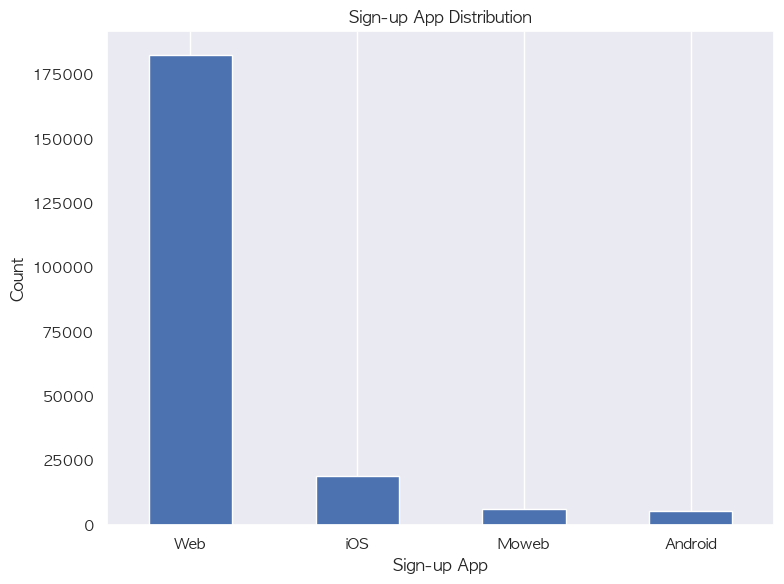

In [7]:
signup_counts = users_df['signup_app'].value_counts()

# 시각화
plt.figure(figsize=(8, 6))
signup_counts.plot(kind='bar')
plt.title('Sign-up App Distribution')
plt.xlabel('Sign-up App')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### signup_app을 기준으로 DAU, WAU, MAU를 구해보자. 

In [8]:
# 원하는 컬럼에 따라 active user을 구하는 함수
def calculate_active_users(users_df, group_col='signup_app', freq='D'):
    # DAU 계산
    if freq == 'D':
        dau = users_df.groupby([pd.Grouper(key='timestamp_first_active', freq=freq), group_col])['id'].nunique().reset_index()
        dau.columns = ['time', group_col, 'DAU']
        return dau

    # WAU 계산
    elif freq == 'W-MON':
        wau = users_df.groupby([pd.Grouper(key='timestamp_first_active', freq=freq), group_col])['id'].nunique().reset_index()
        wau.columns = ['week', group_col, 'WAU']
        return wau

    # MAU 계산
    if freq == 'M':
        mau = users_df.groupby([pd.Grouper(key='timestamp_first_active', freq=freq), group_col])['id'].nunique().reset_index()
        mau.columns = ['month', group_col, 'MAU']
        return mau


In [9]:
dau = calculate_active_users(users_df, group_col='signup_app', freq='D')
dau

,time,signup_app,DAU
0,2009-03-19,Web,1
1,2009-05-23,Web,1
2,2009-06-09,Web,1
3,2009-10-31,Web,1
4,2009-12-08,Web,1
...,...,...,...
3581,2014-06-29,iOS,135
3582,2014-06-30,Android,16
3583,2014-06-30,Moweb,41
3584,2014-06-30,Web,414


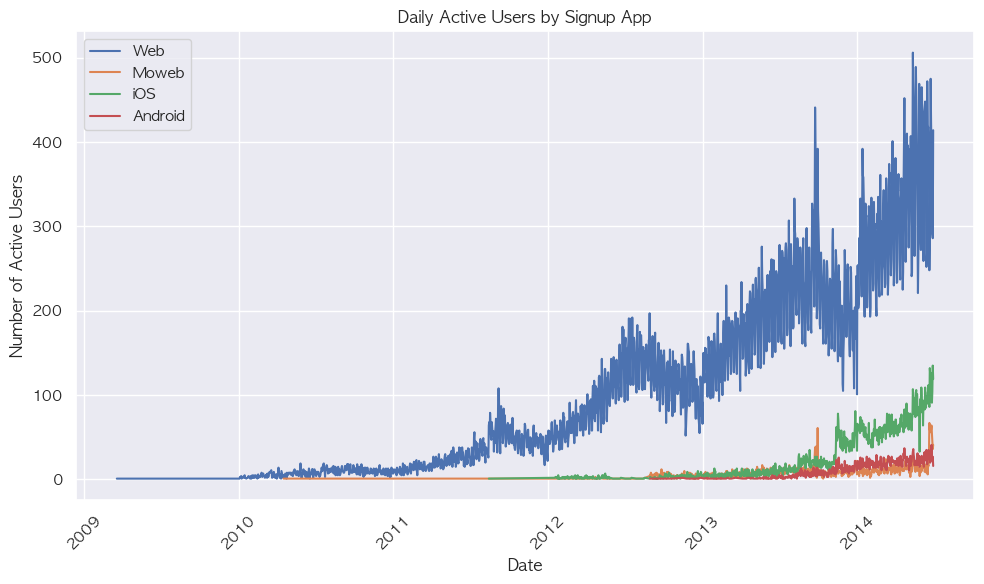

In [10]:
plt.figure(figsize=(10, 6))
for app in dau['signup_app'].unique():
    app_data = dau[dau['signup_app'] == app]
    plt.plot(app_data['time'], app_data['DAU'], label=app)

plt.title('Daily Active Users by Signup App')
plt.xlabel('Date')
plt.ylabel('Number of Active Users')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

In [11]:
wau = calculate_active_users(users_df, group_col='signup_app', freq='W-MON')
wau

,week,signup_app,WAU
0,2009-03-23,Web,1
1,2009-05-25,Web,1
2,2009-06-15,Web,1
3,2009-11-02,Web,1
4,2009-12-14,Web,1
...,...,...,...
563,2014-06-23,iOS,762
564,2014-06-30,Android,183
565,2014-06-30,Moweb,353
566,2014-06-30,Web,2667


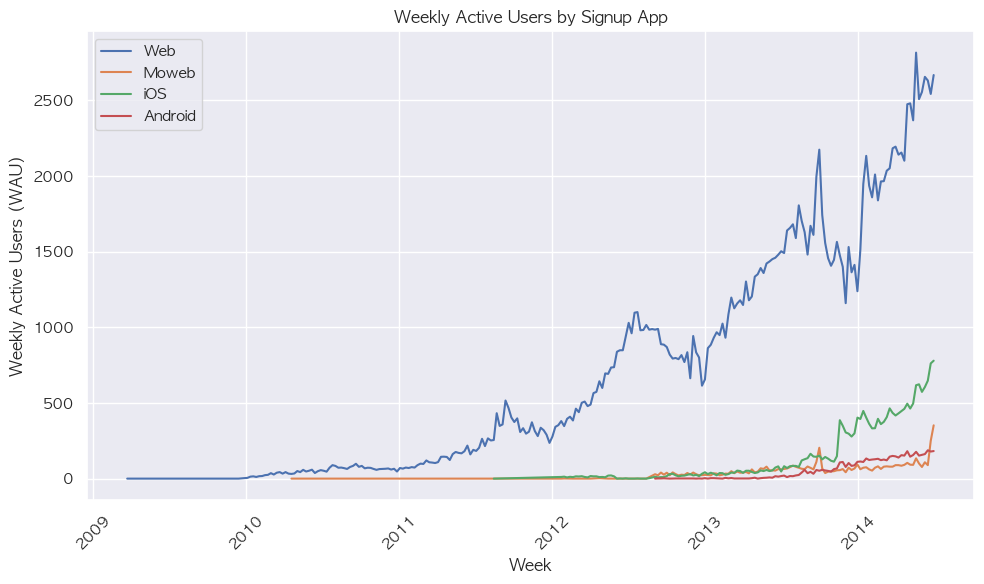

In [12]:
plt.figure(figsize=(10, 6))
for app in wau['signup_app'].unique():
    app_data = wau[wau['signup_app'] == app]
    plt.plot(app_data['week'], app_data['WAU'], label=app)

plt.title('Weekly Active Users by Signup App')
plt.xlabel('Week')
plt.ylabel('Weekly Active Users (WAU)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

In [13]:
mau = calculate_active_users(users_df, group_col='signup_app', freq='M')
mau

/var/folders/xs/f9fm_9vn3sn6nwbyrqy65ch40000gn/T/ipykernel_8496/3993733230.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  mau = users_df.groupby([pd.Grouper(key='timestamp_first_active', freq=freq), group_col])['id'].nunique().reset_index()


,month,signup_app,MAU
0,2009-03-31,Web,1
1,2009-05-31,Web,1
2,2009-06-30,Web,1
3,2009-10-31,Web,1
4,2009-12-31,Web,1
...,...,...,...
138,2014-05-31,iOS,2442
139,2014-06-30,Android,760
140,2014-06-30,Moweb,829
141,2014-06-30,Web,11154


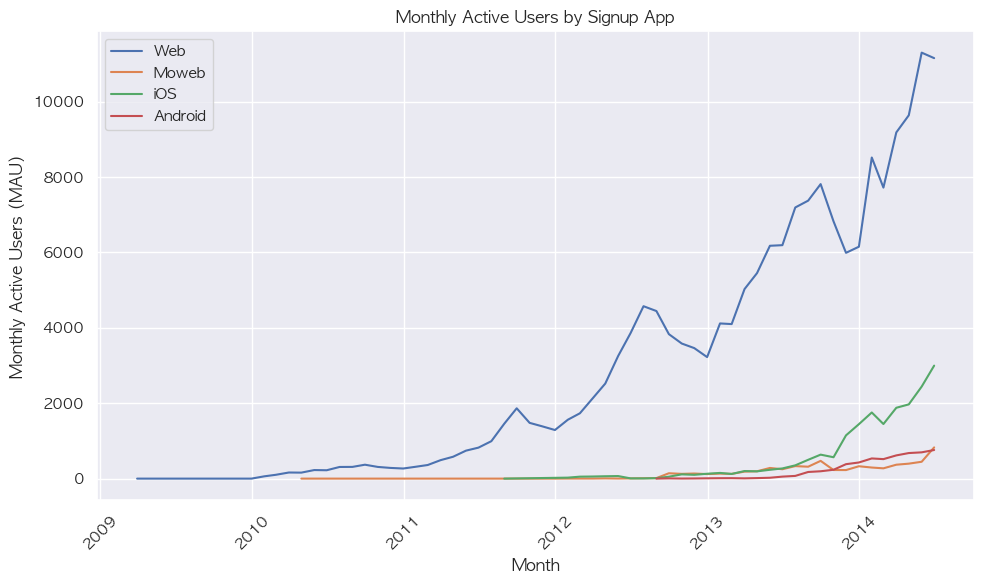

In [14]:
plt.figure(figsize=(10, 6))
# 각 signup_app 별로 선 그래프 그리기
for app in mau['signup_app'].unique():
    app_data = mau[mau['signup_app'] == app]
    plt.plot(app_data['month'], app_data['MAU'], label=app)

# 그래프 레이블과 타이틀 설정
plt.xlabel('Month')
plt.ylabel('Monthly Active Users (MAU)')
plt.title('Monthly Active Users by Signup App')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# ---------------------------------------------

### first_device_type : 사용자가 서비스에 가입할 때 사용한 첫 번째 장치의 유형
- Mac Desktop: Apple의 macOS 운영체제를 탑재한 데스크탑 컴퓨터인 Mac을 의미

- Windows Desktop: Microsoft의 Windows 운영체제를 탑재한 데스크탑 컴퓨터를 의미

- iPhone: Apple의 iOS 운영체제를 탑재한 iPhone 스마트폰을 의미

- Other/Unknown: 다른 유형의 장치이거나 알려지지 않은 장치 유형

- Desktop (Other): 위에서 언급한 Mac Desktop과 Windows Desktop 이외의 데스크탑 컴퓨터를 의미

- Android Tablet: 구글의 Android 운영체제를 탑재한 태블릿을 의미

- iPad: Apple의 iOS 운영체제를 탑재한 iPad 태블릿을 의미

- Android Phone: 구글의 Android 운영체제를 탑재한 스마트폰을 의미

- SmartPhone (Other): iPhone과 Android Phone 이외의 다른 스마트폰을 의미

In [15]:
users_df['first_device_type'].unique()

array(['Mac Desktop', 'Windows Desktop', 'iPhone', 'Other/Unknown',
       'Desktop (Other)', 'Android Tablet', 'iPad', 'Android Phone',
       'SmartPhone (Other)'], dtype=object)

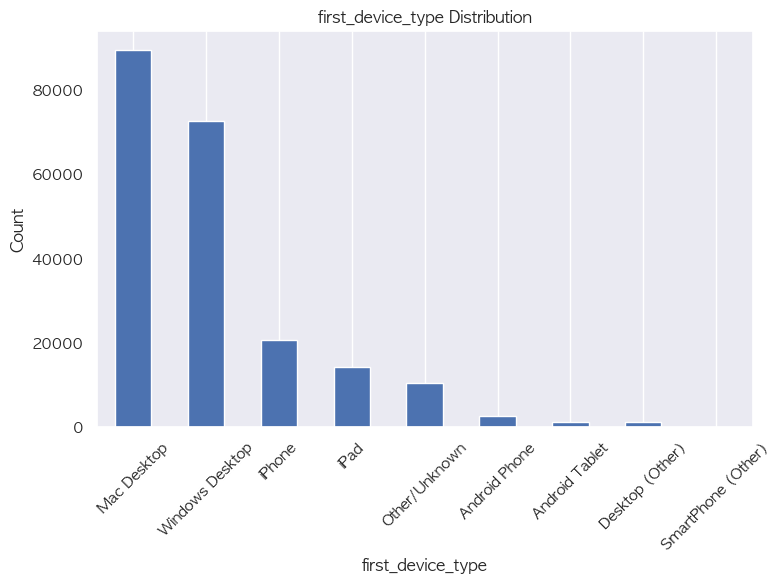

In [16]:
first_device_type_counts = users_df['first_device_type'].value_counts()

# 시각화
plt.figure(figsize=(8, 6))
first_device_type_counts.plot(kind='bar')
plt.title('first_device_type Distribution')
plt.xlabel('first_device_type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [17]:
dau = calculate_active_users(users_df, group_col='first_device_type', freq='D')
dau

,time,first_device_type,DAU
0,2009-03-19,Mac Desktop,1
1,2009-05-23,Mac Desktop,1
2,2009-06-09,Windows Desktop,1
3,2009-10-31,Mac Desktop,1
4,2009-12-08,Mac Desktop,1
...,...,...,...
9018,2014-06-30,Other/Unknown,4
9019,2014-06-30,SmartPhone (Other),1
9020,2014-06-30,Windows Desktop,165
9021,2014-06-30,iPad,37


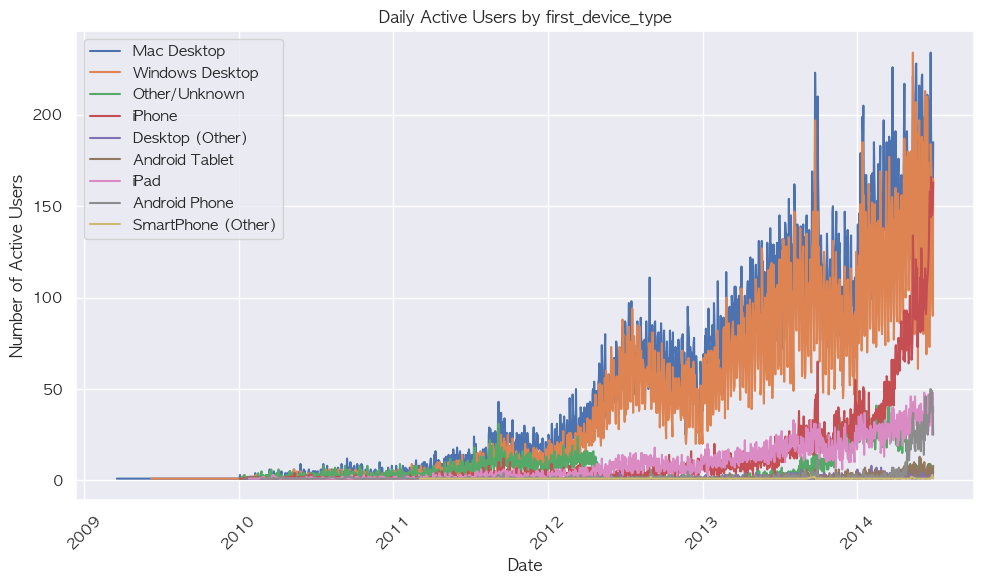

In [18]:
plt.figure(figsize=(10, 6))
for app in dau['first_device_type'].unique():
    app_data = dau[dau['first_device_type'] == app]
    plt.plot(app_data['time'], app_data['DAU'], label=app)

plt.title('Daily Active Users by first_device_type')
plt.xlabel('Date')
plt.ylabel('Number of Active Users')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

In [19]:
wau = calculate_active_users(users_df, group_col='first_device_type', freq='W-MON')
wau

,week,first_device_type,WAU
0,2009-03-23,Mac Desktop,1
1,2009-05-25,Mac Desktop,1
2,2009-06-15,Windows Desktop,1
3,2009-11-02,Mac Desktop,1
4,2009-12-14,Mac Desktop,1
...,...,...,...
1727,2014-06-30,Other/Unknown,39
1728,2014-06-30,SmartPhone (Other),5
1729,2014-06-30,Windows Desktop,1031
1730,2014-06-30,iPad,269


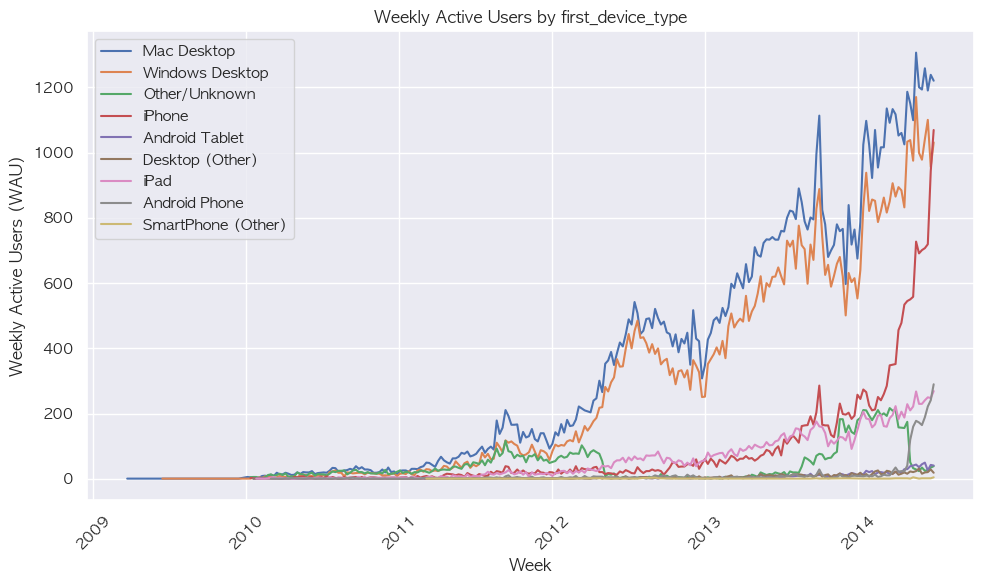

In [20]:
plt.figure(figsize=(10, 6))
for app in wau['first_device_type'].unique():
    app_data = wau[wau['first_device_type'] == app]
    plt.plot(app_data['week'], app_data['WAU'], label=app)

plt.title('Weekly Active Users by first_device_type')
plt.xlabel('Week')
plt.ylabel('Weekly Active Users (WAU)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

In [21]:
mau = calculate_active_users(users_df, group_col='first_device_type', freq='M')
mau

/var/folders/xs/f9fm_9vn3sn6nwbyrqy65ch40000gn/T/ipykernel_8496/3993733230.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  mau = users_df.groupby([pd.Grouper(key='timestamp_first_active', freq=freq), group_col])['id'].nunique().reset_index()


,month,first_device_type,MAU
0,2009-03-31,Mac Desktop,1
1,2009-05-31,Mac Desktop,1
2,2009-06-30,Windows Desktop,1
3,2009-10-31,Mac Desktop,1
4,2009-12-31,Mac Desktop,1
...,...,...,...
449,2014-06-30,Other/Unknown,136
450,2014-06-30,SmartPhone (Other),11
451,2014-06-30,Windows Desktop,4362
452,2014-06-30,iPad,1082


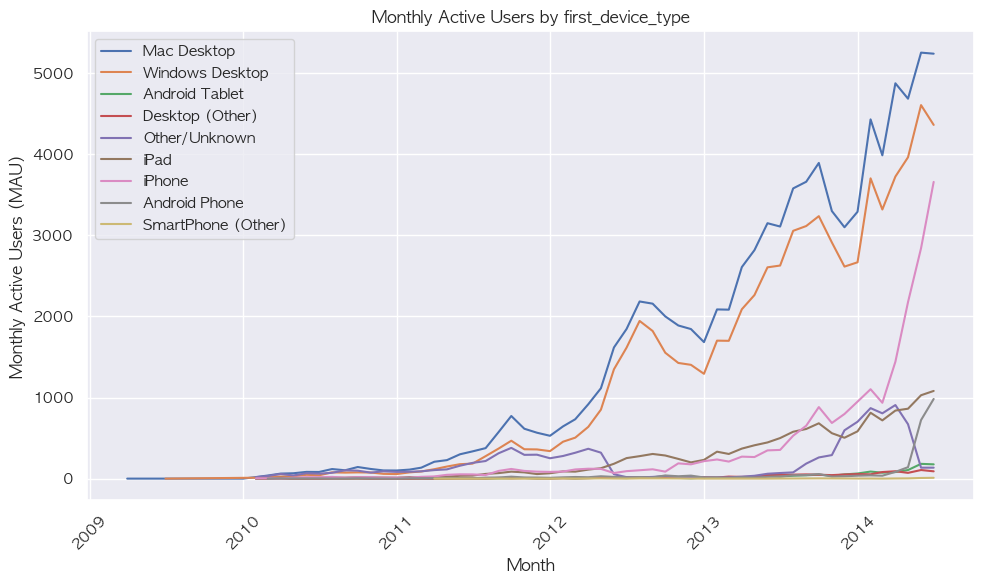

In [22]:
plt.figure(figsize=(10, 6))
# 각 signup_app 별로 선 그래프 그리기
for app in mau['first_device_type'].unique():
    app_data = mau[mau['first_device_type'] == app]
    plt.plot(app_data['month'], app_data['MAU'], label=app)

# 그래프 레이블과 타이틀 설정
plt.xlabel('Month')
plt.ylabel('Monthly Active Users (MAU)')
plt.title('Monthly Active Users by first_device_type')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()